In [1]:
%%time
from windwhisper import WindTurbines, NoisePropagation, NoiseAnalysis, HumanHealth
import xarray as xr

# we can preload the wind speed data, otherwise, the tool will do it every time
filepath_wind_speed = "/Users/romain/GitHub/windwhisper/dev/fixtures/era5_mean_2013-2022_month_by_hour.nc"
filepath_correction = "/Users/romain/GitHub/windwhisper/dev/fixtures/ratio_gwa2_era5.nc"

def wind_speed_data():

    wind_speed = xr.open_dataset(filepath_wind_speed).to_array().mean(dim="month")
    correction = xr.open_dataset(filepath_correction).to_array()
    correction = correction.sel(variable='ratio_gwa2_era5_mean_WS').interp(latitude=wind_speed.latitude, longitude=wind_speed.longitude, method="linear")
    return wind_speed * correction

wind_speed_data = wind_speed_data()

# note: make ensure latitude and longitude coordinates are sorted in ascending order
elevation_data = xr.open_dataset("fixtures/Copernicus_DSM_90m_COG.nc")


CPU times: user 4.2 s, sys: 2.57 s, total: 6.77 s
Wall time: 8.15 s


In [2]:
%%time
wind_turbines = {
    'Turbine 0':
     {
        'diameter': 70.0,
        'hub height': 85.0,
        'position': (43.45111343125036, 5.2518247370645215),
        'power': 2500.0
     },
}

wt = WindTurbines(
    wind_turbines=wind_turbines,
    wind_speed_data=wind_speed_data,
    #retrain_model=True
)

CPU times: user 398 ms, sys: 173 ms, total: 571 ms
Wall time: 514 ms


In [3]:
noise_prop = NoisePropagation(
    wind_turbines=wt.wind_turbines,
    humidity=70,
    temperature=20,
    elevation_data=elevation_data,
)

Using local elevation data


In [4]:
noise_analysis = NoiseAnalysis(
    noise_propagation=noise_prop,
    wind_turbines=wt.wind_turbines,
)

In [5]:
hh = HumanHealth(
    noise_analysis
)

In [6]:
hh.electricity_production

122079544.22235489

In [10]:
hh.electricity_production/(2500*1*1*8760*20)

0.2787204205989838

In [11]:
hh.export_to_excel()

In [7]:
hh.l_den

<xarray.DataArray (lat: 100, lon: 100)> Size: 80kB
array([[107.91788242, 107.91788242, 107.91788242, ..., 107.91788242,
        107.91788242, 107.91788242],
       [107.91788242, 107.91788242, 107.91788242, ..., 107.91788242,
        107.91788242, 107.91788242],
       [107.91788242, 107.91788242, 107.91788242, ..., 107.91788242,
        107.91788242, 107.91788242],
       ...,
       [107.91788242, 107.91788242, 107.91788242, ..., 107.91788242,
        107.91788242, 107.91788242],
       [107.91788242, 107.91788242, 107.91788242, ..., 107.91788242,
        107.91788242, 107.91788242],
       [107.91788242, 107.91788242, 107.91788242, ..., 107.91788242,
        107.91788242, 107.91788242]], shape=(100, 100))
Coordinates:
  * lat      (lat) float64 800B 43.43 43.43 43.43 43.43 ... 43.47 43.47 43.47
  * lon      (lon) float64 800B 5.232 5.232 5.233 5.233 ... 5.271 5.271 5.272
    hour     int64 8B 0
Attributes:
    long_name:  Lden Noise Levels
    units:      dB

In [1]:
from windwhisper.electricity_production import get_capacity_factor

In [2]:
get_capacity_factor(
    43.4963381431904, 5.603112659991827
)

0.27013158798217773

In [6]:
import plotly.graph_objects as go
import numpy as np

# 1. Sum the human_health dataset along each cause to get stacked bars per (lat, lon)
ds = hh.human_health  # assuming shape (cause, lat, lon)

# Extract dimensions
lats = ds.lat.values
lons = ds.lon.values
causes = list(ds.data_vars)

# Flatten lat/lon grid
lon_grid, lat_grid = np.meshgrid(lons, lats)
lat_flat = lat_grid.ravel()
lon_flat = lon_grid.ravel()


total = sum(ds[var] for var in ds.data_vars)

fig = go.Figure(data=[
    go.Surface(
        z=total.values,
        x=ds.lon.values,
        y=ds.lat.values,
        colorscale='Viridis',
        colorbar=dict(title='Total DALYs'),
    )
])

fig.update_layout(
    title='Total DALYs (all causes)',
    scene=dict(
        xaxis_title='Longitude',
        yaxis_title='Latitude',
        zaxis_title='DALYs',
    ),
    height=700
)

fig.show()


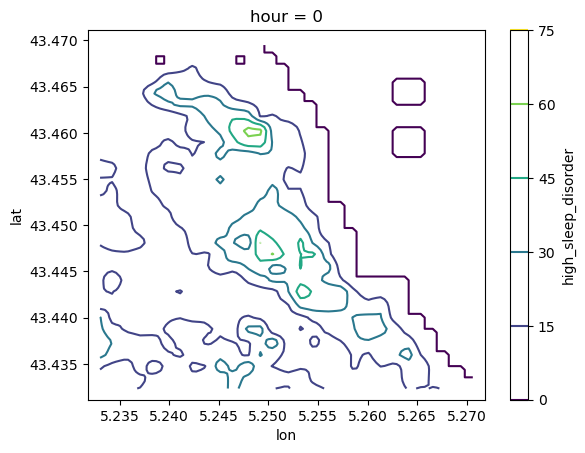

In [12]:
hh.human_health["high_sleep_disorder"].plot.contour(add_colorbar=True)

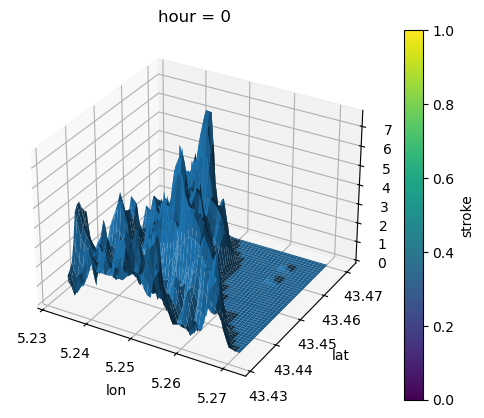

In [16]:
hh.human_health["stroke"].plot.surface(add_colorbar=True)

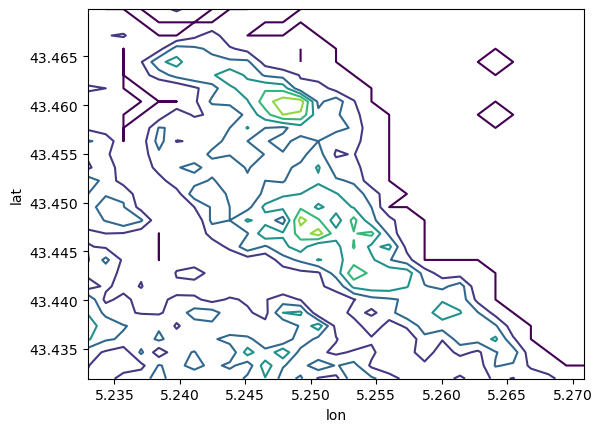

In [7]:
hh.population.plot.contour()

In [5]:
import geopandas as gdp

In [6]:
gdp.datasets.available

[]

In [8]:
import geopandas as gpd
from windwhisper import DATA_DIR
from shapely.geometry import box

bbox = box(
    43.43111343,
    43.47111343,
    5.23182474,
    5.27182474
) 
world = gpd.read_file(DATA_DIR / "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326")

intersecting = gpd.overlay(world, bbox_gdf, how="intersection")
intersecting["area"] = intersecting.geometry.area

/var/folders/cn/pys1j9rn0y7djkhv3hfdtrs00000gn/T/ipykernel_14752/1367153158.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersecting["area"] = intersecting.geometry.area


In [13]:
world[["SOVEREIGNT", "ISO_A2_EH"]].to_csv("country_codes.csv")

In [15]:
world.to_csv("countries.csv")

In [ ]:
world.loc[
    
]

In [10]:
intersecting["ISO_A2"]

0      KE
1      SD
2      TD
3      RU
4     -99
5      NE
6      NG
7      CM
8      CF
9      IL
10     LB
11     PS
12     TN
13     DZ
14     JO
15     IQ
16     SY
17     BG
18     GR
19     TR
20     AL
21     HR
22     IT
23     GE
24     ER
25     YE
26     SA
27    -99
28     CY
29     EG
30     LY
31     ET
32     DJ
33    -99
34     BA
35     MK
36     RS
37     ME
38    -99
39     SS
Name: ISO_A2, dtype: object

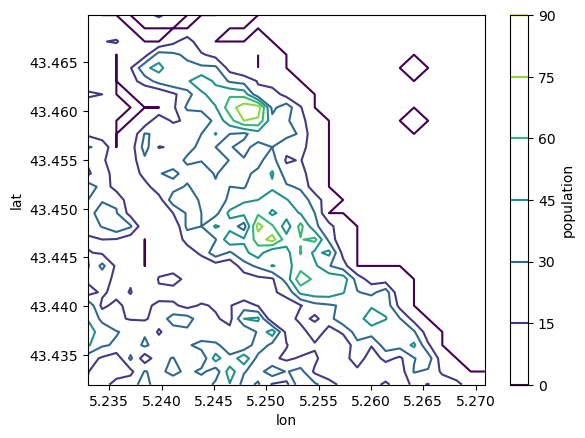

In [17]:
import matplotlib.pyplot as plt
hh.population.plot.contour(add_colorbar=True)


In [18]:
hh.human_health_parameters

{'highly_annoyed': {'road_without_alpinestudies': {'a': 116.4304,
   'b': -4.7342,
   'c': 0.0497,
   'disability_weight': 0.02},
  'road_with_alpinestudies': {'a': 78.927,
   'b': -3.1162,
   'c': 0.0342,
   'disability_weight': 0.02},
  'aircraft': {'a': -50.9693,
   'b': 1.0168,
   'c': 0.0072,
   'disability_weight': 0.02},
  'railway': {'a': 38.1596,
   'b': -2.0554,
   'c': 0.0285,
   'disability_weight': 0.02}},
 'high_sleep_disorder': {'combined': {'a': 19.4312,
   'b': -0.9336,
   'c': 0.0126,
   'disability_weight': 0.07},
  'awakenings': {'a': 8.8986,
   'b': -0.4209,
   'c': 0.0065,
   'disability_weight': 0.07},
  'falling_asleep': {'a': 19.3767,
   'b': -0.9263,
   'c': 0.0122,
   'disability_weight': 0.07},
  'upper estimates': {'a': 28.064,
   'b': -1.3442,
   'c': 0.0181,
   'disability_weight': 0.07},
  'lower estimates': {'a': 10.717,
   'b': -0.5326,
   'c': 0.0072,
   'disability_weight': 0.07}},
 'ischemic_heart_disease': {'road middle': {'a': 1.08, 'threshold': 4

In [15]:
type(elevation_data)

In [14]:
elevation_data = elevation_data.sortby("latitude")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]
Note: you may need to restart the kernel to use updated packages.


In [3]:
elevation_data.to_netcdf("/Users/romain/Github/windwhisper/dev/fixtures/Copernicus_DSM_90m_COG_sorted.nc")

xarray.core.dataset.Dataset

In [4]:
elevation_data.coords

Generate an HTML map of the noise levels

In [3]:
noise_analysis.generate_map(
    filepath="my_noise_map.html"
)

Fetch geoJson contour objects for ambient noise, noise from wind turbines, ambient + wind turbine noise, net wind turbine noise contribution, and noise levels above EU guidelines.

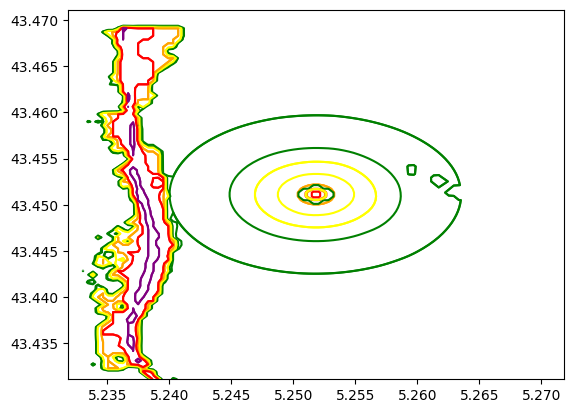

In [ ]:
noise_prop.elevation_grid.plot.surface()

({"features": [{"geometry": {"coordinates": [[5.239395, 43.431113], [5.239097, 43.43139], [5.238978, 43.431517], [5.238919, 43.431922], [5.238693, 43.432116], [5.238289, 43.432212], [5.238151, 43.432326], [5.238289, 43.432458], [5.238536, 43.43273], [5.238468, 43.433134], [5.238289, 43.433299], [5.238038, 43.433538], [5.237885, 43.433688], [5.237707, 43.433942], [5.23769, 43.434346], [5.23768, 43.43475], [5.237689, 43.435154], [5.237697, 43.435558], [5.237687, 43.435962], [5.23768, 43.436366], [5.23768, 43.43677], [5.237694, 43.437174], [5.23771, 43.437578], [5.237885, 43.437773], [5.238099, 43.437982], [5.23812, 43.438386], [5.238289, 43.438579], [5.238516, 43.43879], [5.238531, 43.439194], [5.238693, 43.439341], [5.238961, 43.439598], [5.239009, 43.440002], [5.239097, 43.4401], [5.239377, 43.440406], [5.239392, 43.44081], [5.239392, 43.441214], [5.239502, 43.441538], [5.239555, 43.441618], [5.239805, 43.442023], [5.239815, 43.442427], [5.239906, 43.442606], [5.240075, 43.442831], [5.

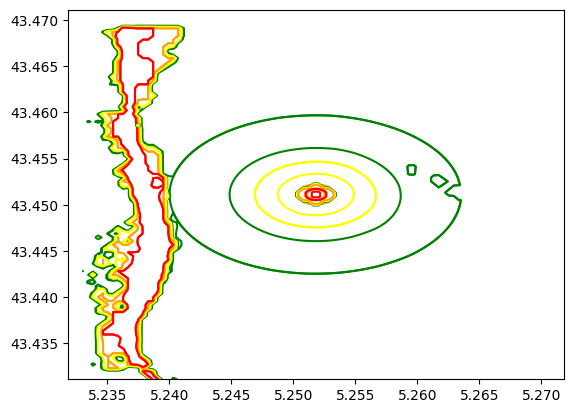

In [5]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def read_elevation_tif(file_path):
    # Open the .tif file using rasterio
    with rasterio.open(file_path) as dataset:
        # Read the first band (assuming a single-band DEM file)
        elevation = dataset.read(1)

        # Get metadata
        metadata = dataset.meta

        # Get georeferencing information
        crs = dataset.crs
        transform = dataset.transform

        # Print georeferencing information
        print(f"Coordinate Reference System (CRS): {crs}")
        print(f"Affine Transformation: {transform}")

        # Plot the elevation data
        plt.figure(figsize=(10, 6))
        plt.imshow(elevation, cmap='terrain', origin='upper')
        plt.colorbar(label='Elevation (m)')
        plt.title('Elevation Map')
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
        plt.show()

        return elevation, metadata, crs, transform

# Example usage
elevation_data, metadata, crs, transform = read_elevation_tif(fp)


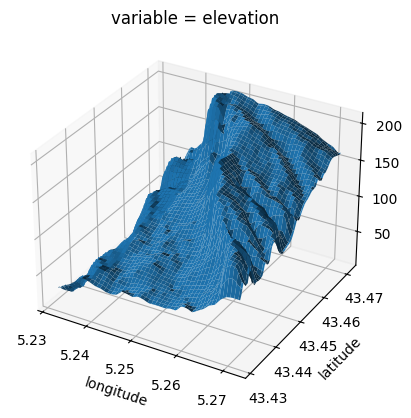

In [6]:
import rasterio

def inspect_tif(file_path):
    with rasterio.open(file_path) as dataset:
        print("Metadata:", dataset.meta)
        print("CRS:", dataset.crs)
        print("Affine Transformation Matrix:\n", dataset.transform)
        print("Width (pixels):", dataset.width)
        print("Height (pixels):", dataset.height)
        print("Bounds:", dataset.bounds)
        print("Resolution (pixel size):", dataset.res)

# Example usage
inspect_tif(fp)


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

def read_elevation_tif(file_path):
    # Open the .tif file using rasterio
    with rasterio.open(file_path) as dataset:
        # Read the first band (assuming a single-band DEM file)
        elevation = dataset.read(1)

        # Get metadata
        metadata = dataset.meta

        # Get georeferencing information
        crs = dataset.crs
        transform = dataset.transform

        # Print georeferencing information
        print(f"Coordinate Reference System (CRS): {crs}")
        print(f"Affine Transformation: {transform}")

        # Compute longitude and latitude coordinates
        width = dataset.width
        height = dataset.height
        lon_min, lat_max = transform * (0, 0)
        lon_max, lat_min = transform * (width, height)

        lons = np.linspace(lon_min, lon_max, width)
        lats = np.linspace(lat_max, lat_min, height)

        # Convert to Xarray Dataset
        elevation_da = xr.DataArray(
            elevation,
            dims=("latitude", "longitude"),
            coords={"latitude": lats, "longitude": lons},
            attrs={"crs": str(crs), "units": "meters", "description": "Elevation data"},
        )

        elevation_ds = xr.Dataset({"elevation": elevation_da})

        # Plot the elevation data
        plt.figure(figsize=(10, 6))
        plt.imshow(elevation, cmap='terrain', origin='upper', extent=[lon_min, lon_max, lat_min, lat_max])
        plt.colorbar(label='Elevation (m)')
        plt.title('Elevation Map')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()

        return elevation_ds

# Example usage
elevation_ds = read_elevation_tif(fp)
elevation_ds.to_netcdf("Copernicus_DSM_90m_COG.nc")

In [ ]:
arr = xr.open_dataset("fixtures/Copernicus_DSM_90m_COG.nc")

In [ ]:
arr.interp(latitude=43.45111343125036, longitude=5.2518247370645215)

In [3]:
 (, )

In [ ]:
 (, )